In [7]:
import numpy as np


class SVM:
    def __init__(self, eta, C, niter, batch_size, verbose):
        self.eta = eta
        self.C = C
        self.niter = niter
        self.batch_size = batch_size
        self.verbose = verbose
        self.reg=0.5

#     def make_one_versus_all_labels(self, y, m):
#         """
#         y : numpy array of shape (n,)
#         m : int (num_classes)
#         returns : numpy array of shape (n, m)
#         """
#         y_elements=len(y)
#         matrix = y_elements*[m*[-1]]
#         arr=np.array(matrix)
#         for i in range(0,len(matrix)):
#             arr[i][y[i]]=1
#         return arr


    def compute_loss(self, x, y):
        """
        x : numpy array of shape (minibatch size, num_features)
        y : numpy array of shape (minibatch size, num_classes)
        returns : float
        """
        loss = 0.0
        dW = np.zeros(self.w.shape) # initialize the gradient as zero
        num_train = x.shape[0]

        #############################################################################
        # Implement a vectorized version of the structured SVM loss, storing the    #
        # result in loss.                                                           #
        #############################################################################
        scores = x.dot(self.w)
        yi_scores = scores[np.arange(scores.shape[0]),y] # http://stackoverflow.com/a/23435843/459241 
        margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)
        margins[np.arange(num_train),y] = 0
        loss = np.mean(np.sum(margins, axis=1))
        loss += 0.5 * self.reg * np.sum(self.w * self.w)

        #############################################################################
        # Implement a vectorized version of the gradient for the structured SVM     #
        # loss, storing the result in dW.                                           #
        #                                                                           #
        # Hint: Instead of computing the gradient from scratch, it may be easier    #
        # to reuse some of the intermediate values that you used to compute the     #
        # loss.                                                                     #
        #############################################################################
        binary = margins
        binary[margins > 0] = 1
        row_sum = np.sum(binary, axis=1)
        binary[np.arange(num_train), y] = -row_sum.T
        dW = np.dot(x.T, binary)

        # Average
        dW /= num_train

        # Regularize
        dW += self.reg*self.w

        return loss

    def compute_gradient(self, x, y):
        """
        x : numpy array of shape (minibatch size, num_features)
        y : numpy array of shape (minibatch size, num_classes)
        returns : numpy array of shape (num_features, num_classes)
        """
        loss = 0.0
        dW = np.zeros(self.w.shape) # initialize the gradient as zero
        num_train = x.shape[0]

        #############################################################################
        # Implement a vectorized version of the structured SVM loss, storing the    #
        # result in loss.                                                           #
        #############################################################################
        scores = x.dot(self.w)
        yi_scores = scores[np.arange(scores.shape[0]),y] # http://stackoverflow.com/a/23435843/459241 
        margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)
        margins[np.arange(num_train),y] = 0
        loss = np.mean(np.sum(margins, axis=1))
        loss += 0.5 * self.reg * np.sum(self.w * self.w)

        #############################################################################
        # Implement a vectorized version of the gradient for the structured SVM     #
        # loss, storing the result in dW.                                           #
        #                                                                           #
        # Hint: Instead of computing the gradient from scratch, it may be easier    #
        # to reuse some of the intermediate values that you used to compute the     #
        # loss.                                                                     #
        #############################################################################
        binary = margins
        binary[margins > 0] = 1
        print(binary[0:5])
        row_sum = np.sum(binary, axis=1)
        print(row_sum[0:5],row_sum.shape)
        binary[np.arange(num_train), y] = -row_sum.T
        dW = np.dot(x.T, binary)
    
        # Average
        dW /= num_train

        # Regularize
        dW += self.reg*self.w
        return dW



    # Batcher function
    def minibatch(self, iterable1, iterable2, size=1):
        l = len(iterable1)
        n = size
        for ndx in range(0, l, n):
            index2 = min(ndx + n, l)
            yield iterable1[ndx: index2], iterable2[ndx: index2]

    def infer(self, x):
        """
        x : numpy array of shape (num_examples_to_infer, num_features)
        returns : numpy array of shape (num_examples_to_infer, num_classes)
        """
        s=x.dot(self.w)
        y_inf=np.argmax(s,axis=1)
        y_pred=y_inf
        
        return y_pred

    def compute_accuracy(self, y_inferred, y):
        """
        y_inferred : numpy array of shape (num_examples, num_classes)
        y : numpy array of shape (num_examples, num_classes)
        returns : float
        """

        correct=0
        for i in range(0,len(y)):
            if y[i]==y_inferred[i]:
                correct+=1
        return correct/len(y)

    def fit(self, x_train, y_train, x_test, y_test):
        """
        x_train : numpy array of shape (number of training examples, num_features)
        y_train : numpy array of shape (number of training examples, num_classes)
        x_test : numpy array of shape (number of training examples, nujm_features)
        y_test : numpy array of shape (number of training examples, num_classes)
        returns : float, float, float, float
        """
        self.num_features = x_train.shape[1]
        self.m = y_train.max() + 1
#         y_train = self.make_one_versus_all_labels(y_train, self.m)
#         y_test = self.make_one_versus_all_labels(y_test, self.m)
        self.w =np.zeros([self.num_features, self.m])

        train_losses = []
        train_accs = []
        test_losses = []
        test_accs = []

        for iteration in range(self.niter):
            # Train one pass through the training set
            for x, y in self.minibatch(x_train, y_train, size=self.batch_size):
                grad = self.compute_gradient(x, y)
                self.w -= self.eta * grad

            # Measure loss and accuracy on training set
            train_loss = self.compute_loss(x_train, y_train)
            y_inferred = self.infer(x_train)
            train_accuracy = self.compute_accuracy(y_inferred, y_train)

            # Measure loss and accuracy on test set
            test_loss = self.compute_loss(x_test, y_test)
            y_inferred = self.infer(x_test)
            test_accuracy = self.compute_accuracy(y_inferred, y_test)

            if self.verbose:
                print(f"Iteration {iteration} | Train loss {train_loss:.04f} | Train acc {train_accuracy:.04f} |"
                      f" Test loss {test_loss:.04f} | Test acc {test_accuracy:.04f}")

            # Record losses, accs
            train_losses.append(train_loss)
            train_accs.append(train_accuracy)
            test_losses.append(test_loss)
            test_accs.append(test_accuracy)

        return train_losses, train_accs, test_losses, test_accs


# DO NOT MODIFY THIS FUNCTION
def load_data():
    # Load the data files
    print("Loading data...")
    x_train = np.load("train_features_cifar100_reduced.npz")["train_data"]
    x_test = np.load("test_features_cifar100_reduced.npz")["test_data"]
    y_train = np.load("train_labels_cifar100_reduced.npz")["train_label"]
    y_test = np.load("test_labels_cifar100_reduced.npz")["test_label"]

    # normalize the data
    mean = x_train.mean(axis=0)
    std = x_train.std(axis=0)
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    # add implicit bias in the feature
    x_train = np.concatenate([x_train, np.ones((x_train.shape[0], 1))], axis=1)
    x_test = np.concatenate([x_test, np.ones((x_test.shape[0], 1))], axis=1)

    return x_train, y_train, x_test, y_test


if __name__ == "__main__":

    x_train, y_train, x_test, y_test = load_data()
#     train_losses_dic={}
#     train_accs_dic={}
#     test_losses_dic={}
#     test_accs_dic={}
#     C=[0.1]
#     for i in range(0,len(C)):
#         svm = SVM(eta=0.001, C=C[i], niter=100, batch_size=5000, verbose=False)
#         train_losses, train_accs, test_losses, test_accs = svm.fit(x_train, y_train, x_test, y_test)
#         train_losses_dic[i]=train_losses
#         train_accs_dic[i]=train_accs
#         test_losses_dic[i]=test_losses
#         test_accs_dic[i]=test_accs
#         print(i)
    print("Fitting the model...")
    svm = SVM(eta=0.001, C=0.1, niter=2, batch_size=5000, verbose=True)
    train_losses, train_accs, test_losses, test_accs = svm.fit(x_train, y_train, x_test, y_test)

    # # to infer after training, do the following:
    # y_inferred = svm.infer(x_test)

    ## to compute the gradient or loss before training, do the following:
    # y_train_ova = svm.make_one_versus_all_labels(y_train, 8) # one-versus-all labels

    # loss = svm.compute_loss(x_train, y_train_ova)


Loading data...
Fitting the model...
[[1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1.]]
[[7.]
 [7.]
 [7.]
 [7.]
 [7.]] (5000, 1)
[[1. 0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 0.]
 [1. 0. 0. 1. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1.]]
[[7.]
 [7.]
 [6.]
 [5.]
 [7.]] (5000, 1)
[[1. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1.]]
[[7.]
 [3.]
 [1.]
 [5.]
 [7.]] (5000, 1)
[[1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0.]]
[[7.]
 [5.]
 [7.]
 [4.]
 [7.]] (5000, 1)
Iteration 0 | Train loss 4.6859 | Train acc 0.3280 | Test loss 4.7587 | Test acc 0.3210
[[1. 0. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 1. 1.]]
[[6.]
 [7.]
 [7.]
 [2.]
 [5.]] 

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [24]:
train_losses_dic[0]

[39.175546246821064,
 66.28388489011333,
 116.68580969479706,
 207.34965814883253,
 371.8372702780705,
 674.8043157113584,
 1241.9801681073532,
 2320.3854120551946,
 4399.974720195939,
 8460.218165381928,
 16471.414598680192,
 32417.195406977673,
 64384.1038285736,
 128839.55599815266,
 259399.9904694396,
 524820.9966914216,
 1065936.4787603586,
 2171550.5599509687,
 4434428.297605711,
 9072035.990216209,
 18586206.514570292,
 38120148.43077586,
 78250413.02256377,
 160731897.15111053,
 330320371.6462074,
 679103567.7123607,
 1396577952.109153,
 2872718056.358523,
 5910123310.961864,
 12160689114.801413,
 25024443029.00238,
 51499720745.56504,
 105991634873.86977,
 218151631840.7869,
 449014964433.95355,
 924219322996.0962,
 1902384923230.8767,
 3915874385628.6113,
 8060546526204.631,
 16592214733141.793,
 34154458630460.645,
 70306081372994.7,
 144723899100398.94,
 297912728048636.25,
 613251996321793.9,
 1262378923717986.2,
 2598610296514608.5,
 5349252260619665.0,
 1.101147229998464

Text(0.5, 1.0, 'Training Loss-Graph')

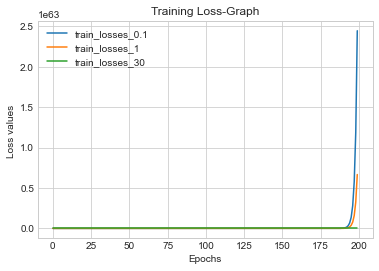

In [23]:

plt.plot(train_losses_dic[0],label='train_losses_0.1')
plt.plot(train_losses_dic[1],label='train_losses_1')
plt.plot(train_losses_dic[2],label='train_losses_30')
plt.xlabel('Epochs')
plt.ylabel('Loss values ')
plt.legend()
plt.title('Training Loss-Graph')


Text(0.5, 1.0, 'Training Accuracy-Graph')

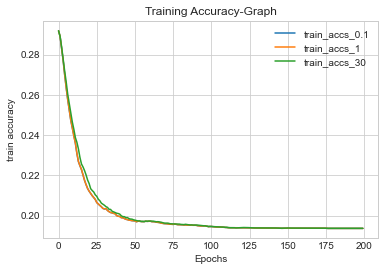

In [11]:

plt.plot(train_accs_dic[0],label='train_accs_0.1')
plt.plot(train_accs_dic[1],label='train_accs_1')
plt.plot(train_accs_dic[2],label='train_accs_30')
plt.xlabel('Epochs')
plt.ylabel('train accuracy')
plt.legend()
plt.title('Training Accuracy-Graph')


Text(0.5, 1.0, 'Test Loss-Graph')

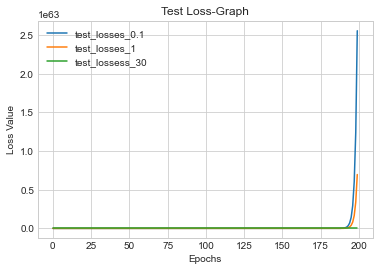

In [12]:

plt.plot(test_losses_dic[0],label='test_losses_0.1')
plt.plot(test_losses_dic[1],label='test_losses_1')
plt.plot(test_losses_dic[2],label='test_lossess_30')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.title('Test Loss-Graph')


Text(0.5, 1.0, 'Test accuracy-Graph')

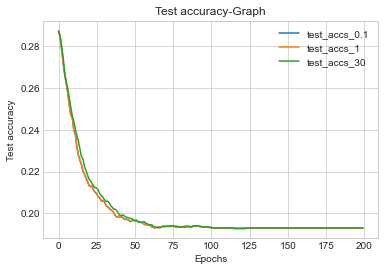

In [6]:

plt.plot(test_accs_dic[0],label='test_accs_0.1')
plt.plot(test_accs_dic[1],label='test_accs_1')
plt.plot(test_accs_dic[2],label='test_accs_30')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.legend()
plt.title('Test accuracy-Graph')

In [ ]:
binary = margins
binary[margins > 0] = 1
row_sum = np.sum(binary, axis=1)
binary[np.arange(num_train), y] = -row_sum.T
dW = np.dot(x.T, binary)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18